<a href="https://www.kaggle.com/code/lumarian/league-of-legends-10-min-prediction-model?scriptVersionId=207023075" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Predicting Win Probability at 10 Minutes in a League of Legends Game
I was always curious about how win probability is calculated live on the overlay during pro matches, so I wanted to try it out for myself. I'm using data with a sample size of around 10k ranked games in high Diamond to Masters elo, provided by Kaggle user  Yi Lan Ma.

The data is pretty old in terms of the game, as it was posted 4 years ago. I'm curious if the meta has changed so much since then that a model trained on this data would result in a lot of error if tested on data from current games.

This is also my first time building a decision tree, so it's probably not that good.

In [1]:
import numpy as np
import pandas as pd
import math, statistics, matplotlib.pyplot as plt
import scikitplot as skplt

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_text, plot_tree
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC

from imblearn.over_sampling import SMOTE

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

from sklearn.metrics import roc_curve, roc_auc_score

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/league-of-legends-diamond-ranked-games-10-min/high_diamond_ranked_10min.csv


In [2]:
# reading in dataset
lolpath="/kaggle/input/league-of-legends-diamond-ranked-games-10-min/high_diamond_ranked_10min.csv"
loldat = pd.read_csv(lolpath)

## 1. Preprocessing
There are lot of features in the raw data. A lot of these features are essentially the same thing, but before I get rid of them, I want to see the correlation for myself, using a correlation heat map.

In [3]:
old = len(loldat)
loldat = loldat.dropna() #Removing any missing values
loldat = loldat.drop_duplicates() # Removing any duplicates
print('Removed {} observations. The resulting dataset has {} observations.'.format(old-len(loldat), len(loldat)))

Removed 0 observations. The resulting dataset has 9879 observations.


In [4]:
loldat.head()

,gameId,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,...,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
0,4519157822,0,28,2,1,9,6,11,0,0,...,0,16567,6.8,17047,197,55,-643,8,19.7,1656.7
1,4523371949,0,12,1,0,5,5,5,0,0,...,1,17620,6.8,17438,240,52,2908,1173,24.0,1762.0
2,4521474530,0,15,0,0,7,11,4,1,1,...,0,17285,6.8,17254,203,28,1172,1033,20.3,1728.5
3,4524384067,0,43,1,0,4,5,5,1,0,...,0,16478,7.0,17961,235,47,1321,7,23.5,1647.8
4,4436033771,0,75,4,0,6,6,6,0,0,...,0,17404,7.0,18313,225,67,1004,-230,22.5,1740.4


Since League is a competitive game, the stats by themselves don't off much valuable insight towards win probability. I'm more interested stat relative to the enemy team, so I'll make some new features based on the difference of the stats I'm interested in.

In [5]:
### Creating new variables to represent the difference between stats
def get_diff(blue, red):
    diff = blue-red
    return diff

lol_blue = ['blueWardsPlaced', 'blueKills', 'blueDeaths', 'blueAssists','blueEliteMonsters','blueTowersDestroyed','blueAvgLevel']
difflist = []
for blue in lol_blue:
    stat = blue[4:]
    red = "red"+stat
    diff = stat+"diff"
    difflist.append(diff)
    loldat[diff] = loldat.apply(lambda x: get_diff(blue = x[blue], red = x[red]),  axis=1)

loldiffs = loldat[difflist]
loldiffs.insert(1, "blueWins", loldat.blueWins, True)
loldiffs.insert(2, "blueGoldDiff", loldat.blueGoldDiff, True)
loldiffs.insert(2, "blueFirstBlood", loldat.blueGoldDiff, True)

# Final Features
lol_features = ['blueGoldDiff', 'WardsPlaceddiff', 'Killsdiff', 'Assistsdiff', 'EliteMonstersdiff', 'TowersDestroyeddiff', 'AvgLeveldiff', 'blueFirstBlood']

In [6]:
### Splitting data into training and testing sets
X = loldiffs[lol_features]
y = loldiffs.blueWins
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=1)

## Models
- Random Forest
- Decision Tree
- XGBoost
- Bernoulli Naive Bayes
- SVM

In [7]:
### Function to generate a report for model evaluation
def get_report(y_test, y_pred):
    confmat =  pd.DataFrame(confusion_matrix(y_test, y_pred),
                      index=['True[0]','True[1]'],
                      columns=['Predict[0]', 'Predict[1]'])
    print(classification_report(y_test, y_pred))
    print('F1: %.3f' % f1_score(y_true=y_test, y_pred=y_pred))
    return confmat

### Random Forest
Random Forest model turned out with a decent accuracy and f1-score. It sets a baseline for the other models.

In [8]:
rf = RandomForestClassifier(n_estimators=200, criterion='gini', max_depth=10,
                            min_samples_split=20, ccp_alpha=0.00, oob_score=True,
                            max_features='sqrt')
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
get_report(y_pred, y_test)

              precision    recall  f1-score   support

           0       0.73      0.74      0.74       986
           1       0.74      0.73      0.73       990

    accuracy                           0.74      1976
   macro avg       0.74      0.74      0.74      1976
weighted avg       0.74      0.74      0.74      1976

F1: 0.734


,Predict[0],Predict[1]
True[0],733,253
True[1],269,721


### Decision Tree

In [9]:
tree = DecisionTreeClassifier(criterion='entropy',max_depth=2, min_samples_split=20,ccp_alpha=0.01 )
tree.fit(X_train, y_train)
tree_ypred = tree.predict(X_test)
get_report(y_test, tree_ypred)

              precision    recall  f1-score   support

           0       0.69      0.82      0.75      1002
           1       0.77      0.63      0.69       974

    accuracy                           0.72      1976
   macro avg       0.73      0.72      0.72      1976
weighted avg       0.73      0.72      0.72      1976

F1: 0.693


,Predict[0],Predict[1]
True[0],817,185
True[1],359,615


### XGBoost

In [10]:
xgb = XGBClassifier(n_estimators=200, max_depth=3)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
get_report(y_test, y_pred)


              precision    recall  f1-score   support

           0       0.74      0.72      0.73      1002
           1       0.72      0.74      0.73       974

    accuracy                           0.73      1976
   macro avg       0.73      0.73      0.73      1976
weighted avg       0.73      0.73      0.73      1976

F1: 0.728


,Predict[0],Predict[1]
True[0],717,285
True[1],253,721


### Naive Bayes

In [11]:
bnb =  BernoulliNB(alpha=1.0)
bnb.fit(X_train, y_train)
y_pred = bnb.predict(X_test)
get_report(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.74      0.72      0.73      1002
           1       0.72      0.74      0.73       974

    accuracy                           0.73      1976
   macro avg       0.73      0.73      0.73      1976
weighted avg       0.73      0.73      0.73      1976

F1: 0.728


,Predict[0],Predict[1]
True[0],720,282
True[1],255,719


### SVM

In [12]:
svm = SVC(probability=True)
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
get_report(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.74      0.72      0.73      1002
           1       0.72      0.74      0.73       974

    accuracy                           0.73      1976
   macro avg       0.73      0.73      0.73      1976
weighted avg       0.73      0.73      0.73      1976

F1: 0.730


,Predict[0],Predict[1]
True[0],723,279
True[1],254,720


## Model Selection

In [13]:
models = ['Random Forest', 'Decision Tree', 'XGBoost', 'Naive Bayes', 'SVM']
f1 = [0.736, 0.693, 0.728, 0.728, 0.730]
acc = [0.73, 0.72, 0.73, 0.73, 0.73]
prec = [0.73, 0.72, 0.73, 0.73, 0.73]
recall = [0.73, 0.72, 0.73, 0.73, 0.73]
pd.DataFrame({'Model': models, 'F-1 Score': f1, 'Accuracy': acc, 'Precision': prec, 'Recall': recall})

,Model,F-1 Score,Accuracy,Precision,Recall
0,Random Forest,0.736,0.73,0.73,0.73
1,Decision Tree,0.693,0.72,0.72,0.72
2,XGBoost,0.728,0.73,0.73,0.73
3,Naive Bayes,0.728,0.73,0.73,0.73
4,SVM,0.730,0.73,0.73,0.73


All the models performed similary in terms of accuracy. Multiple runs of the models would help us approach the true value of its metrics, but for some reason my code to do that is running really slow in Kaggle when it works fine in vscode locally :(( On a brighter note, we select the Random Forest model as the final model since it has the highest F-1 score.

## Model Evaluation
Plotting some plots for evaluation of the final model, which was Random Forest.

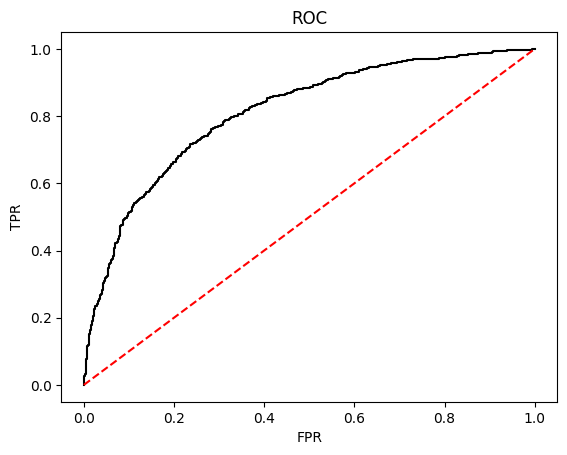

0.810790124063987


In [14]:
y_score = rf.predict(X_test)
y_score_prob = rf.predict_proba(X_test)[:,1]

fpr, tpr, thresholds = roc_curve(y_test, y_score_prob)
plt.plot(fpr, tpr, 'k')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC')
plt.show()

print(roc_auc_score(y_test, y_score_prob))

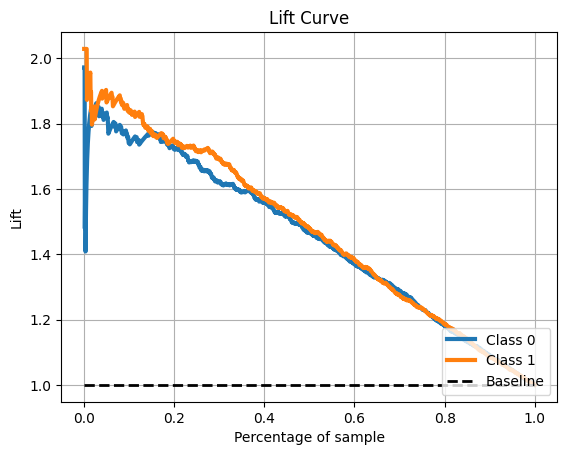

In [15]:
skplt.metrics.plot_lift_curve(y_test, rf.predict_proba(X_test))
plt.show()

Not the ideal outcome when it comes to the life curve. The ROC curve looks about as expected, and the AUC score is not bad. 

## Conclusion

The model can definitely be improved with techniques such as oversampling, pipelines, or more parameter hypertuning. More exploratory data analysis would also help me discover patterns in the data and allow me to respond to it. For now, the model will stay like this and I'll pick this back up when I get the chance.